In [1]:
import numpy as np
import os

import torch 
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import Adam

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def generator_loss(G_out, D_out,alpha, beta, power):
    loss_e = F.binary_cross_entropy(D_out, torch.full_like(D_out, alpha))
    
    center = torch.mean(G_out, dim=0)
    distance = torch.subtract(G_out, center)
    norm = torch.norm(distance, dim=1, p=power)
    loss_d = torch.reciprocal(torch.mean(norm))
    
    return loss_e + beta * loss_d

def discriminator_loss(y_pred_real, y_pred_gen, gamma):
    real_loss = F.binary_cross_entropy(y_pred_real, torch.ones_like(y_pred_real))
    gen_loss = F.binary_cross_entropy(y_pred_gen, torch.zeros_like(y_pred_real))
    
    return real_loss + gamma * gen_loss

In [3]:
def plot_boundary(G, D, args, title='', single_plot=True):    
    #color background
    if single_plot:
        plt.figure()
    x1s = np.linspace(0, 40, 40)
    x2s = np.linspace(0, 40, 40)
    x1, x2 = np.meshgrid(x1s, x2s)
    Input = np.column_stack([x1.ravel(), x2.ravel()])
    with torch.no_grad():
        Output = D(torch.tensor(Input, device=args.device, dtype=torch.float32)).cpu().numpy()
    Z = Output.reshape(40,40)
    ticks = np.arange(0, 1.01, 0.2)
    plt.contourf(x1, x2, Z, ticks, cmap='coolwarm', alpha=0.6, vmin=0, vmax=1)
    if single_plot:
        plt.colorbar()

    X_real = get_data(args.distribution, 500).numpy()
    
    X_gen = get_data('noise', 200).to(args.device)
    with torch.no_grad():
        Out = G(X_gen).cpu().numpy()
    plt.scatter(X_real[:, 0],X_real[:, 1],color='red', alpha=0.8, label='real')
    plt.scatter(Out[:, 0],Out[:, 1],color='blue', alpha=0.8, label='generated')
    plt.xlim(0,40)
    plt.ylim(0,40)
    plt.title(title)
  #  plt.show()
    if single_plot:
        plt.legend()
        plt.savefig("{}/{}.png".format(args.pictures_dir, title), dpi=600)

In [4]:
class Hyperparameters:
    alpha = 0.5
    beta = 15
    gamma = 0.1
    power = 2
    batch_size = 100
    distribution = 'normal'
    models_dir = "saved_models"
    pictures_dir = "pictures"
   # device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = 'cpu'
    
args = Hyperparameters()


os.makedirs(args.models_dir, exist_ok=True)
os.makedirs(args.pictures_dir, exist_ok=True)


In [5]:
def generate_triangular_distribution(n):
    r1, r2 = np.random.rand(n), np.random.rand(n)
    sqrt_r1 = np.sqrt(r1)
    barycentric = (1 - sqrt_r1, sqrt_r1 * (1 - r2), r2 * sqrt_r1)
    points = np.array([[10], [10]]) * barycentric[0] + np.array([[30], [10]]) * barycentric[1] + np.array([[20], [30]]) * barycentric[2]
    return torch.tensor(points.T, dtype=torch.float32)


def generate_bow_shape_distribution(n):
    theta = np.linspace(0, np.pi, n)
    x = 10 * np.cos(theta) + np.random.normal(0, 1.8, size=n) + 20
    y = 15 * np.sin(theta) + np.random.normal(0, 1.8, size=n) + 10
    return torch.tensor(np.vstack((x, y)).T, dtype=torch.float32)


def generate_oval_distribution(n):
    angles = np.random.uniform(0, 2 * np.pi, n)
    radii = np.sqrt(np.random.uniform(0, 1, n)) 
    x = 10 * radii * np.cos(angles) + 20
    y = 5 * radii * np.sin(angles) + 20
    return torch.tensor(np.vstack((x, y)).T, dtype=torch.float32)

def generate_square_distribution(n):
    x = np.random.uniform(15, 25, n)
    y = np.random.uniform(15, 25, n)
    return torch.tensor(np.vstack((x, y)).T, dtype=torch.float32)



def get_data(distribution, n):

    if distribution == 'noise':
        return torch.normal(0, 1, size=(n, 2))
    
    if distribution == 'normal':
        return torch.normal(20, 3, size=(n, 2))
    
    if distribution == 'square':
        return generate_square_distribution(n)
    
    if distribution == 'triangular':
        return generate_triangular_distribution(n)
    
    if distribution == 'bow_shaped':
        return generate_bow_shape_distribution(n)
    
    if distribution == 'oval':
        return generate_oval_distribution(n)
    
        
        

In [6]:
class Generator(nn.Module):
    def __init__(self, hidden_dim = 10):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 2)
       
    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = self.fc3(out) + x
        return out
    
    
class Discriminator(nn.Module):
    def __init__(self, hidden_dim = 15):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
       
    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = F.sigmoid(self.fc3(out))
        return out

In [7]:
def train_discriminator(D, G, D_optimizer, args):
    X_real = get_data(args.distribution, args.batch_size).to(args.device)
    X_gen = get_data('noise', args.batch_size).to(args.device)
    
    y_pred_real = D(X_real)
    y_pred_gen = D(G(X_gen))
    loss = discriminator_loss(y_pred_real, y_pred_gen, args.gamma)

    D_optimizer.zero_grad()    
    loss.backward()
    D_optimizer.step()
    
    return loss.item()

def train_generator(D, G, G_optimizer, args):
    X_gen = get_data('noise', args.batch_size).to(args.device)
    G_out = G(X_gen)
    D_out = D(G_out)
    loss = generator_loss(G_out, D_out, args.alpha, args.beta, args.power)

    G_optimizer.zero_grad()    
    loss.backward()
    G_optimizer.step()
    
    return loss.item()

pretrain_epoch:50, d_loss:1.1400412321090698
epoch:5000, d_loss:1.4029161930084229, g_loss:0.6617643237113953


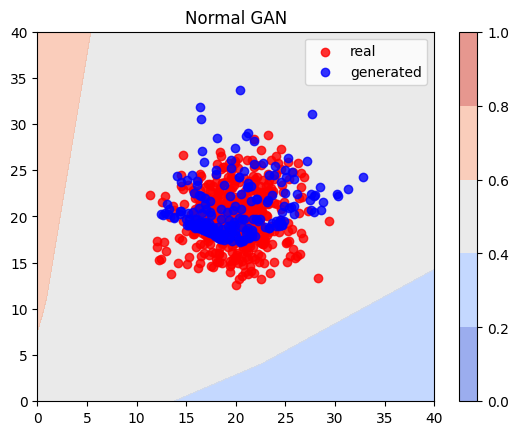

In [8]:
torch.manual_seed(0)
np.random.seed(0)

args.alpha = 1
args.beta = 0
args.gamma = 1

G = Generator(8).to(args.device)
D = Discriminator(8).to(args.device)

G_optimizer = Adam(G.parameters(), lr=1e-3)
D_optimizer = Adam(D.parameters(), lr=1e-3)



for epoch in range(1, 50+1):
    d_loss = train_discriminator(D, G, D_optimizer, args)
print("pretrain_epoch:{}, d_loss:{}".format(epoch, d_loss))
        

for epoch in range(1, 5_000+1):
    d_loss = train_discriminator(D, G, D_optimizer, args)
    g_loss = train_generator(D, G, G_optimizer, args)
    if epoch % 5000 == 0:
        print("epoch:{}, d_loss:{}, g_loss:{}".format(epoch, d_loss, g_loss))
plot_boundary(G, D, args, title='Normal GAN'.format(epoch))
torch.save(G.state_dict(), "{}/model_baseline_G.pth".format(args.models_dir))
torch.save(D.state_dict(), "{}/model_baseline_D.pth".format(args.models_dir))

pretrain_epoch:50, d_loss:0.0629006028175354
epoch:5000, d_loss:0.19182270765304565, g_loss:2.4852352142333984
epoch:10000, d_loss:0.14062795042991638, g_loss:2.4894299507141113
epoch:15000, d_loss:0.19432973861694336, g_loss:2.6934502124786377
epoch:20000, d_loss:0.09424293041229248, g_loss:2.6933000087738037
epoch:25000, d_loss:0.1618269383907318, g_loss:2.5522422790527344
epoch:30000, d_loss:0.09472578763961792, g_loss:2.604943037033081


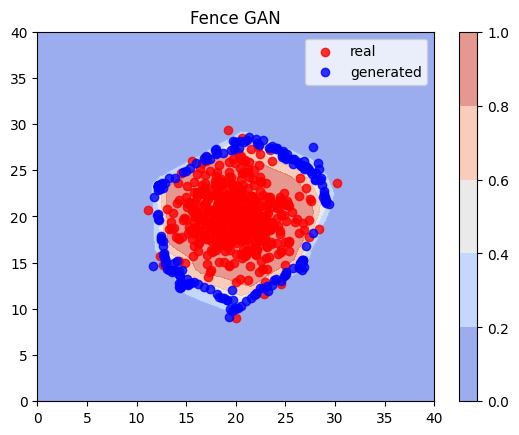

In [60]:
torch.manual_seed(0)
np.random.seed(0)


args.alpha = 0.6
args.beta = 15
args.gamma = 0.1

G = Generator(16).to(args.device)
D = Discriminator(8).to(args.device)

G_optimizer = Adam(G.parameters(), lr=1e-3)
D_optimizer = Adam(D.parameters(), lr=1e-3)



for epoch in range(1, 50+1):
    d_loss = train_discriminator(D, G, D_optimizer, args)
print("pretrain_epoch:{}, d_loss:{}".format(epoch, d_loss))
        

for epoch in range(1, 30_000+1):
    d_loss = train_discriminator(D, G, D_optimizer, args)
    g_loss = train_generator(D, G, G_optimizer, args)
    if epoch % 5000 == 0:
        print("epoch:{}, d_loss:{}, g_loss:{}".format(epoch, d_loss, g_loss))

plot_boundary(G, D, args, title='Fence GAN'.format(epoch))
torch.save(G.state_dict(), "{}/model1_G.pth".format(args.models_dir))
torch.save(D.state_dict(), "{}/model1_D.pth".format(args.models_dir))

In [88]:
point_1 = torch.tensor([[20, 20]], dtype=torch.float32, device=args.device)
point_2 = torch.tensor([[10, 30]], dtype=torch.float32, device=args.device)

with torch.no_grad():
    print(D(point_1))
    print(D(point_2))

tensor([[0.9997]])
tensor([[3.7709e-06]])


In [32]:
alpha_list = [0.2,0.4,0.6,0.8,1]
beta_list = [0,10,20,30,40]
gamma_list = [0.2,0.4,0.6,0.8,1]

# default values for alpha, beta and gamma
default_values = [0.5, 15, 0.1]
grid = [alpha_list, beta_list, gamma_list]
args.distribution = 'normal'

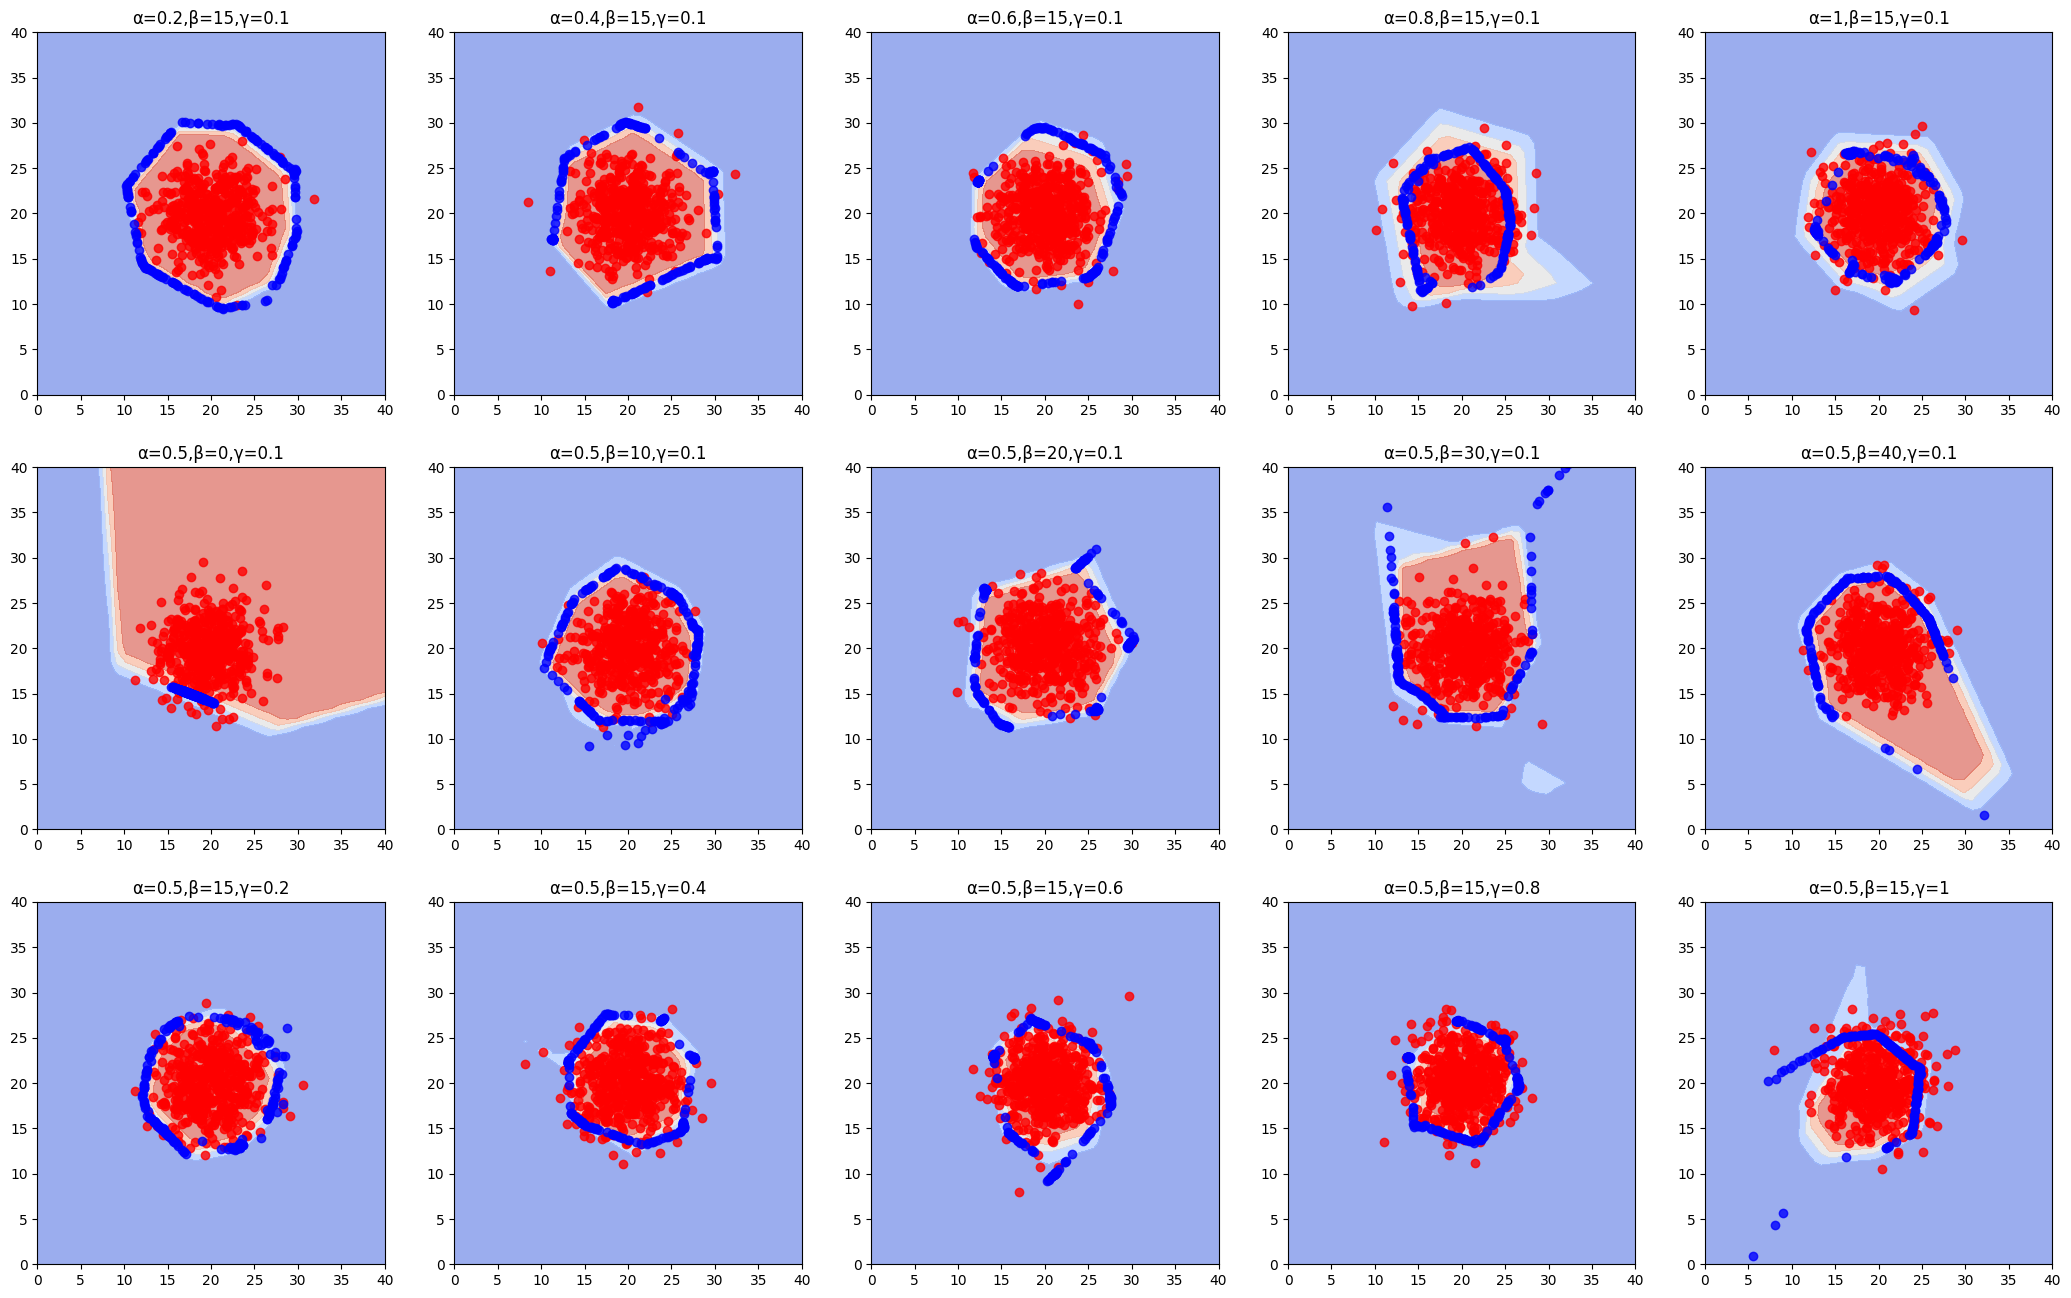

In [33]:
torch.manual_seed(123)
np.random.seed(123)
plt.figure(figsize=(26,16))
rows = len(grid)
columns = len(grid[0])
for hyperparamter in range(rows):
    current_values = default_values.copy()
    for value in range(columns):
        current_values[hyperparamter] = grid[hyperparamter][value]
        args.alpha, args.beta, args.gamma = current_values

        G = Generator(16).to(args.device)
        D = Discriminator(8).to(args.device)
        G_optimizer = Adam(G.parameters(), lr=1e-3)
        D_optimizer = Adam(D.parameters(), lr=1e-3)
        for epoch in range(1, 50+1):
            d_loss = train_discriminator(D, G, D_optimizer, args)

        for epoch in range(1, 30_000+1):
            d_loss = train_discriminator(D, G, D_optimizer, args)
            g_loss = train_generator(D, G, G_optimizer, args)

        plt.subplot(rows, columns, hyperparamter*columns + value+1)
        title="α={},β={},γ={}".format(args.alpha, args.beta, args.gamma)
        plot_boundary(G, D, args, title, False)

epoch:10, d_loss:0.07215012609958649
epoch:20, d_loss:0.06902332603931427
epoch:30, d_loss:0.0685238316655159
epoch:40, d_loss:0.06457306444644928
epoch:50, d_loss:0.06121731922030449
epoch:1000, d_loss:0.19829414784908295, g_loss:1.623488187789917
epoch:2000, d_loss:0.44513213634490967, g_loss:1.7137322425842285
epoch:3000, d_loss:0.05639027804136276, g_loss:2.0612287521362305
epoch:4000, d_loss:0.08288037776947021, g_loss:1.6644742488861084
epoch:5000, d_loss:0.11372765898704529, g_loss:2.094315528869629
epoch:6000, d_loss:0.08770221471786499, g_loss:2.3885397911071777
epoch:7000, d_loss:0.0797431617975235, g_loss:3.0732855796813965
epoch:8000, d_loss:0.1082872599363327, g_loss:3.5513689517974854
epoch:9000, d_loss:0.08386816084384918, g_loss:3.678271770477295
epoch:10000, d_loss:0.10284851491451263, g_loss:3.851578950881958
epoch:11000, d_loss:0.12168696522712708, g_loss:3.914706230163574
epoch:12000, d_loss:0.10786241292953491, g_loss:3.8791422843933105
epoch:13000, d_loss:0.071134

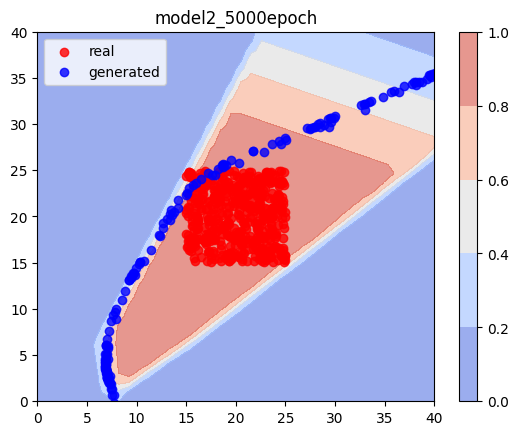

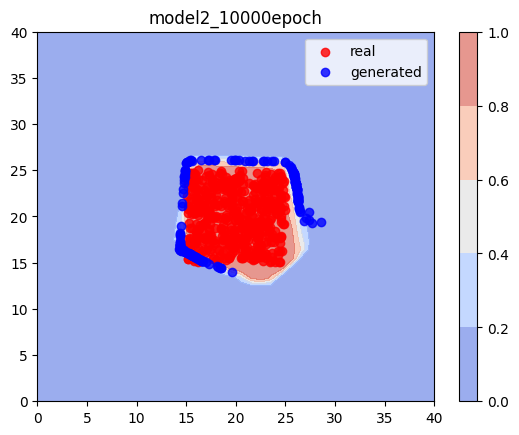

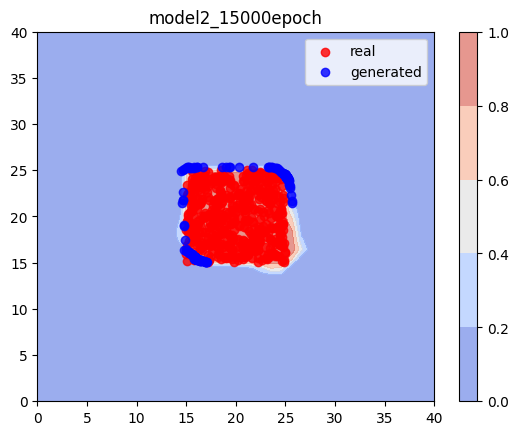

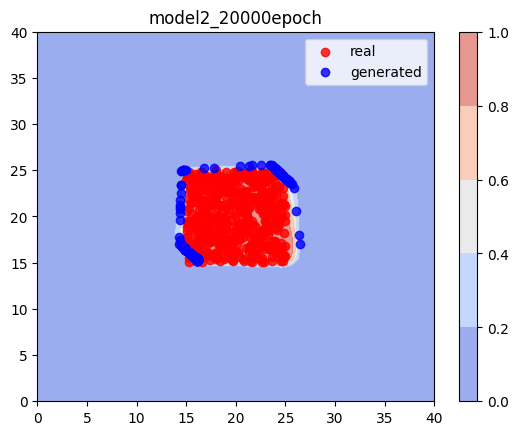

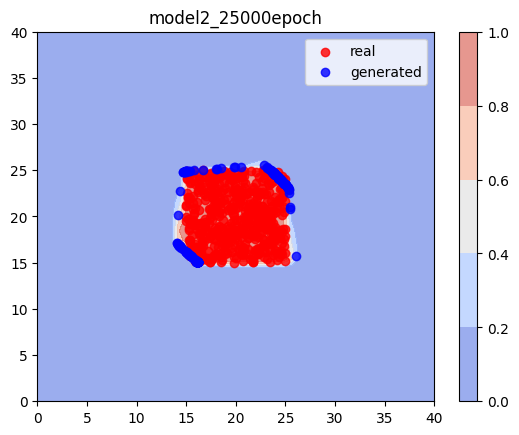

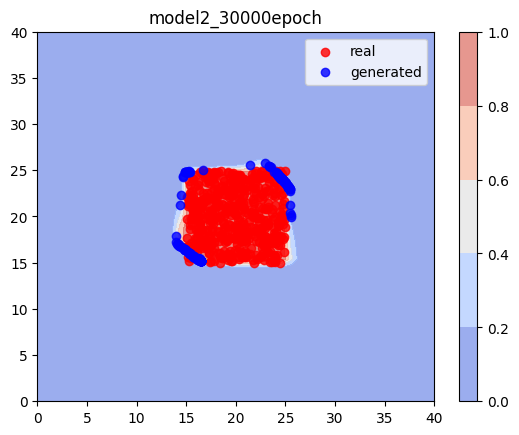

In [60]:
torch.manual_seed(0)
np.random.seed(0)

G = Generator(16).to(args.device)
D = Discriminator(8).to(args.device)

args.distribution = 'square'
args.alpha = 0.5
args.beta = 20
args.gamma=0.1

G_optimizer = Adam(G.parameters(), lr=1e-3)
D_optimizer = Adam(D.parameters(), lr=1e-3)



for epoch in range(1, 50+1):
    d_loss = train_discriminator(D, G, D_optimizer, args)
    if epoch % 10 == 0:
        print("epoch:{}, d_loss:{}".format(epoch, d_loss))
        

for epoch in range(1, 30_000+1):
    d_loss = train_discriminator(D, G, D_optimizer, args)
    g_loss = train_generator(D, G, G_optimizer, args)
    if epoch % 1000 == 0:
        print("epoch:{}, d_loss:{}, g_loss:{}".format(epoch, d_loss, g_loss))
    if epoch % 5000 == 0:
        plot_boundary(G, D, args, title='model2_{}epoch'.format(epoch))
torch.save(G.state_dict(), "{}/model2_G.pth".format(args.models_dir))
torch.save(D.state_dict(), "{}/model2_D.pth".format(args.models_dir))

epoch:10, d_loss:0.07516269385814667
epoch:20, d_loss:0.07169443368911743
epoch:30, d_loss:0.07160469889640808
epoch:40, d_loss:0.06727245450019836
epoch:50, d_loss:0.06299609690904617
epoch:1000, d_loss:0.19999492168426514, g_loss:1.4508984088897705
epoch:2000, d_loss:0.3054221272468567, g_loss:1.086381196975708
epoch:3000, d_loss:0.08367309719324112, g_loss:1.7055103778839111
epoch:4000, d_loss:0.15018850564956665, g_loss:2.1110098361968994
epoch:5000, d_loss:0.1408177763223648, g_loss:2.0857067108154297
epoch:6000, d_loss:0.1525903046131134, g_loss:2.482919692993164
epoch:7000, d_loss:0.16205474734306335, g_loss:2.229813575744629
epoch:8000, d_loss:0.18110814690589905, g_loss:2.256865978240967
epoch:9000, d_loss:0.12552382051944733, g_loss:2.300445318222046
epoch:10000, d_loss:0.1664101779460907, g_loss:2.3612253665924072
epoch:11000, d_loss:0.14159440994262695, g_loss:2.2600255012512207
epoch:12000, d_loss:0.08861012756824493, g_loss:2.151200771331787
epoch:13000, d_loss:0.08371032

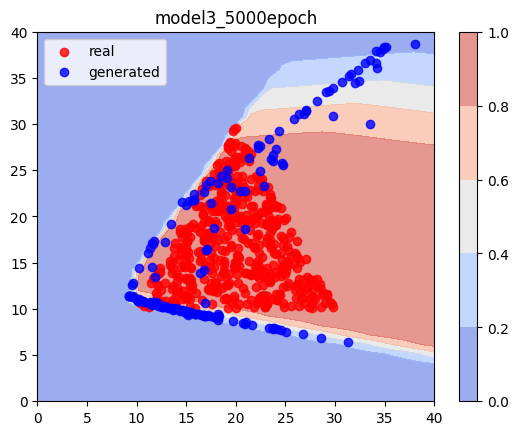

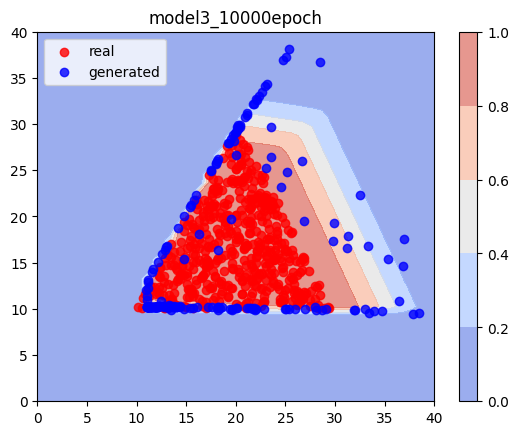

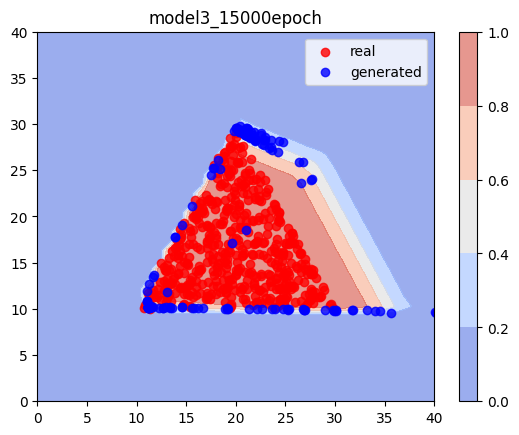

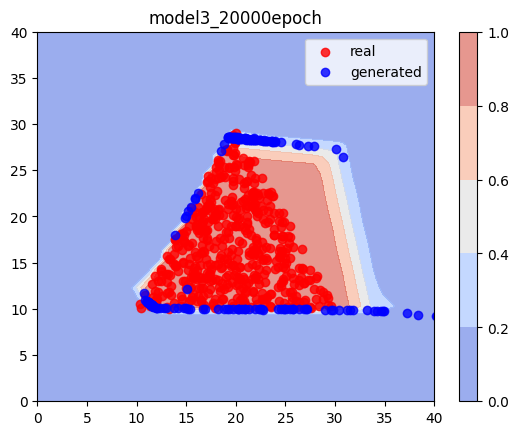

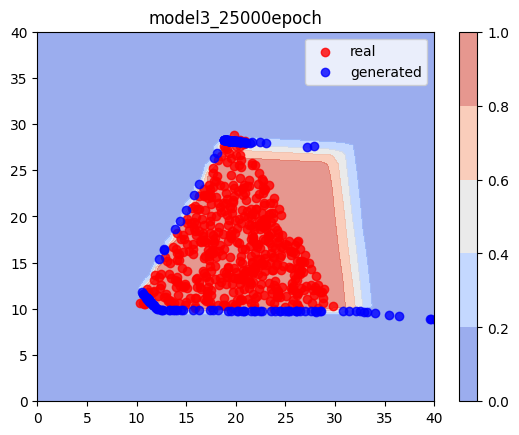

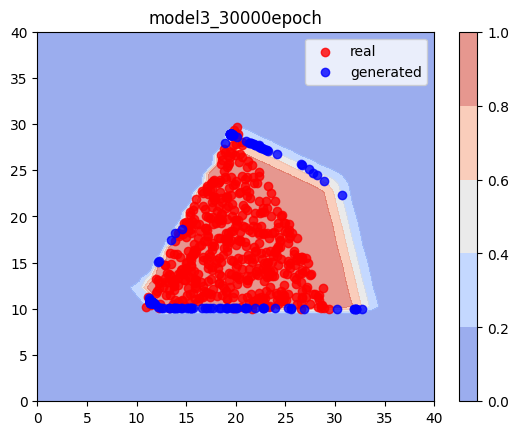

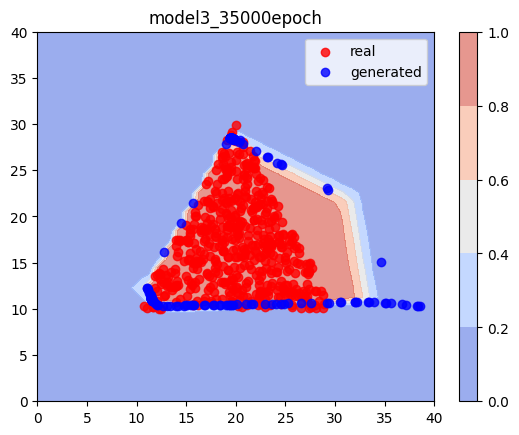

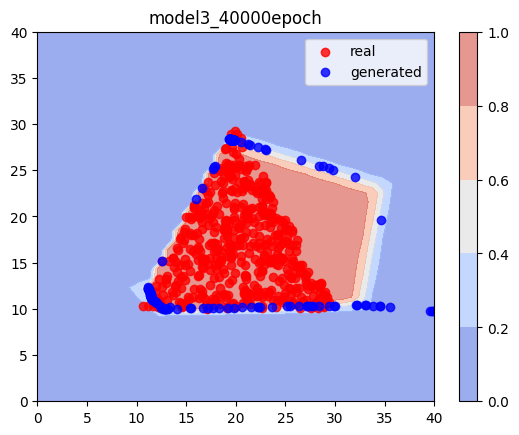

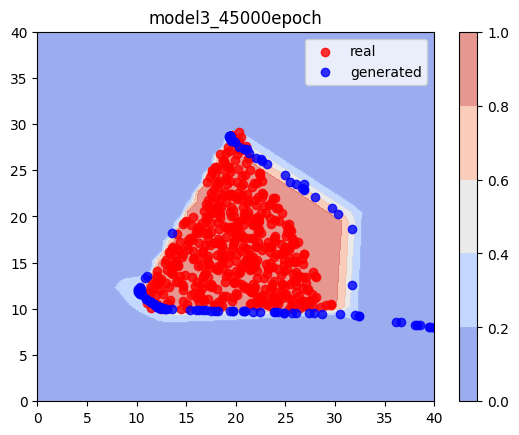

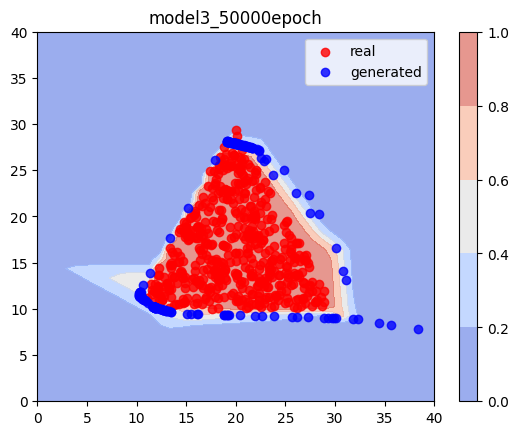

In [14]:
torch.manual_seed(0)
np.random.seed(0)

G = Generator(16).to(args.device)
D = Discriminator(8).to(args.device)

args.distribution = 'triangular'
args.alpha = 0.5
args.beta = 15
args.gamma=0.1

G_optimizer = Adam(G.parameters(), lr=1e-3)
D_optimizer = Adam(D.parameters(), lr=1e-3)



for epoch in range(1, 50+1):
    d_loss = train_discriminator(D, G, D_optimizer, args)
    if epoch % 10 == 0:
        print("epoch:{}, d_loss:{}".format(epoch, d_loss))
        

for epoch in range(1, 50_000+1):
    d_loss = train_discriminator(D, G, D_optimizer, args)
    g_loss = train_generator(D, G, G_optimizer, args)
    if epoch % 1000 == 0:
        print("epoch:{}, d_loss:{}, g_loss:{}".format(epoch, d_loss, g_loss))
    if epoch % 5000 == 0:
        plot_boundary(G, D, args, title='model3_{}epoch'.format(epoch))
torch.save(G.state_dict(), "{}/model3_G.pth".format(args.models_dir))
torch.save(D.state_dict(), "{}/model3_D.pth".format(args.models_dir))

epoch:10, d_loss:0.07191745191812515
epoch:20, d_loss:0.06853100657463074
epoch:30, d_loss:0.0682220607995987
epoch:40, d_loss:0.0645187720656395
epoch:50, d_loss:0.06129884719848633
epoch:1000, d_loss:0.3696773648262024, g_loss:1.481071949005127
epoch:2000, d_loss:0.22636142373085022, g_loss:1.3153469562530518
epoch:3000, d_loss:0.1864440143108368, g_loss:2.1419758796691895
epoch:4000, d_loss:0.1895952969789505, g_loss:2.3801069259643555
epoch:5000, d_loss:0.15516343712806702, g_loss:2.4461183547973633
epoch:6000, d_loss:0.23551756143569946, g_loss:2.364574432373047
epoch:7000, d_loss:0.17563429474830627, g_loss:2.412823438644409
epoch:8000, d_loss:0.23056499660015106, g_loss:2.359748601913452
epoch:9000, d_loss:0.22683310508728027, g_loss:2.371767282485962
epoch:10000, d_loss:0.21130965650081635, g_loss:2.270509719848633
epoch:11000, d_loss:0.22876974940299988, g_loss:2.3277711868286133
epoch:12000, d_loss:0.2099108099937439, g_loss:2.2643580436706543
epoch:13000, d_loss:0.1962644308

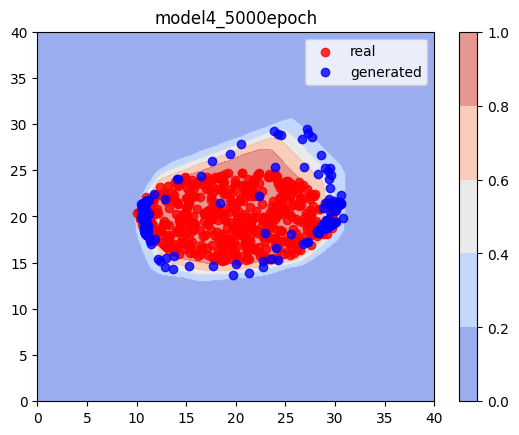

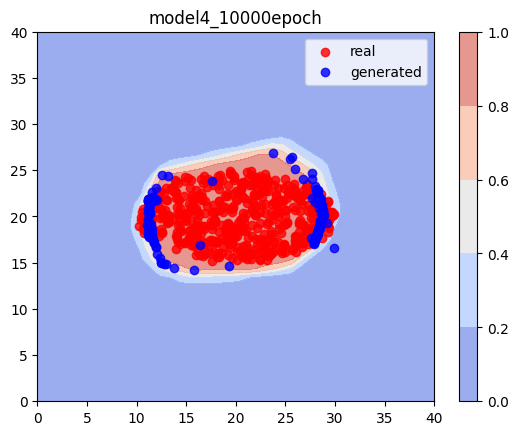

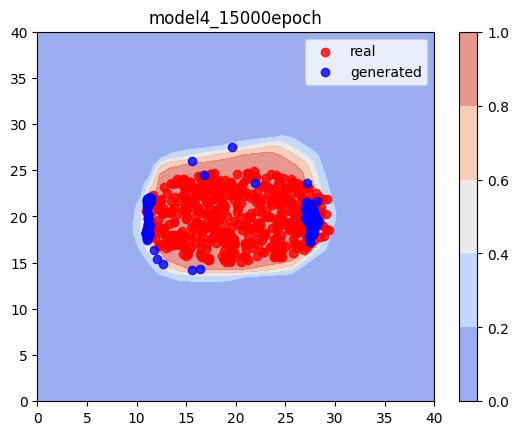

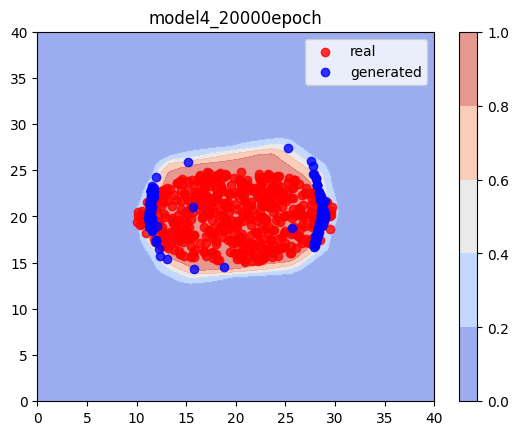

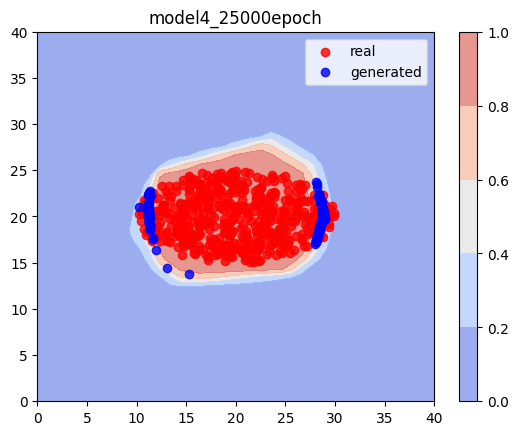

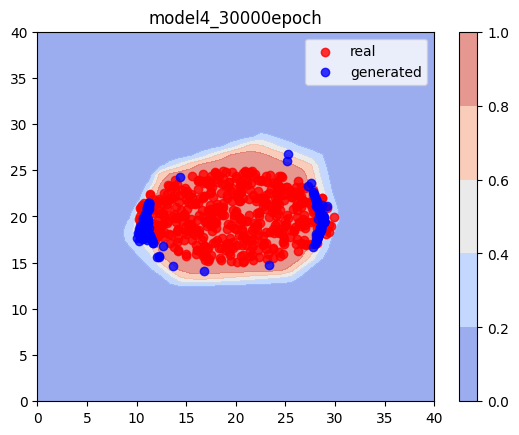

In [57]:
torch.manual_seed(0)
np.random.seed(0)

G = Generator(16).to(args.device)
D = Discriminator(8).to(args.device)

args.distribution = 'oval'
args.alpha = 0.8
args.beta = 15
args.gamma=0.1

G_optimizer = Adam(G.parameters(), lr=1e-3)
D_optimizer = Adam(D.parameters(), lr=1e-3)



for epoch in range(1, 50+1):
    d_loss = train_discriminator(D, G, D_optimizer, args)
    if epoch % 10 == 0:
        print("epoch:{}, d_loss:{}".format(epoch, d_loss))
        

for epoch in range(1, 30_000+1):
    d_loss = train_discriminator(D, G, D_optimizer, args)
    g_loss = train_generator(D, G, G_optimizer, args)
    if epoch % 1000 == 0:
        print("epoch:{}, d_loss:{}, g_loss:{}".format(epoch, d_loss, g_loss))
    if epoch % 5000 == 0:
        plot_boundary(G, D, args, title='model4_{}epoch'.format(epoch))
torch.save(G.state_dict(), "{}/model4_G.pth".format(args.models_dir))
torch.save(D.state_dict(), "{}/model4_D.pth".format(args.models_dir))

epoch:10, d_loss:0.284853458404541
epoch:20, d_loss:0.2721470296382904
epoch:30, d_loss:0.27101805806159973
epoch:40, d_loss:0.2564423084259033
epoch:50, d_loss:0.24397240579128265
epoch:1000, d_loss:0.6424891948699951, g_loss:0.9045675992965698
epoch:2000, d_loss:0.6539826393127441, g_loss:0.9556176066398621
epoch:3000, d_loss:0.7671332359313965, g_loss:1.1123597621917725
epoch:4000, d_loss:0.7241557836532593, g_loss:1.150463581085205
epoch:5000, d_loss:0.7226763963699341, g_loss:1.1328233480453491
epoch:6000, d_loss:0.6589730381965637, g_loss:1.0847411155700684
epoch:7000, d_loss:0.7348695397377014, g_loss:1.1421902179718018
epoch:8000, d_loss:0.7734678387641907, g_loss:1.0748984813690186
epoch:9000, d_loss:0.7761214971542358, g_loss:1.069772481918335
epoch:10000, d_loss:0.7608093023300171, g_loss:1.1193625926971436
epoch:11000, d_loss:0.7569421529769897, g_loss:1.0566048622131348
epoch:12000, d_loss:0.7259185314178467, g_loss:1.0684480667114258
epoch:13000, d_loss:0.6778982877731323

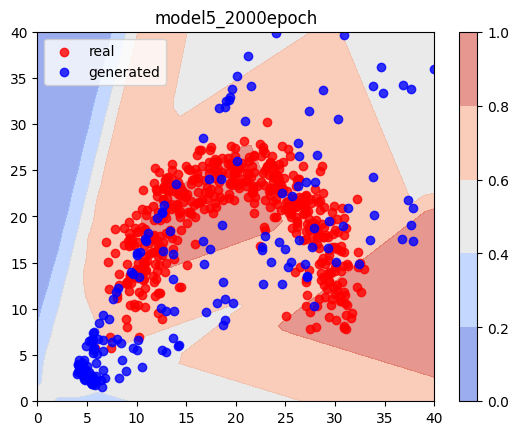

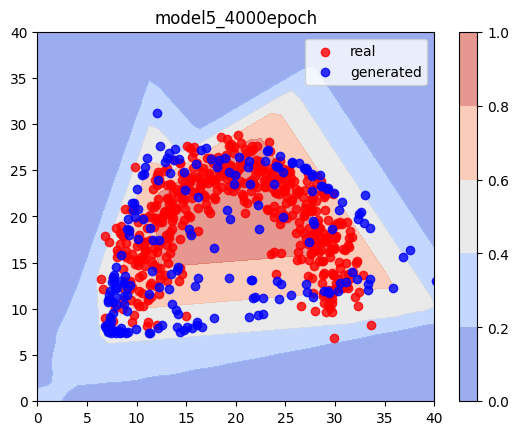

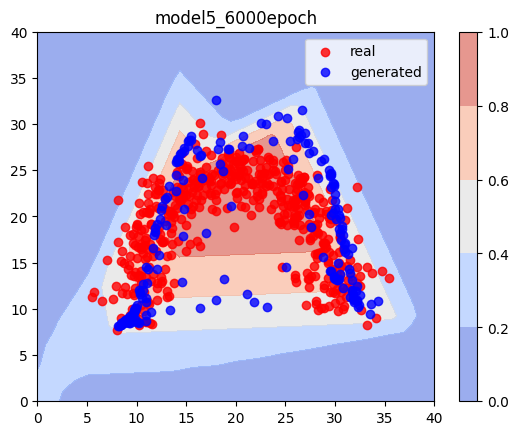

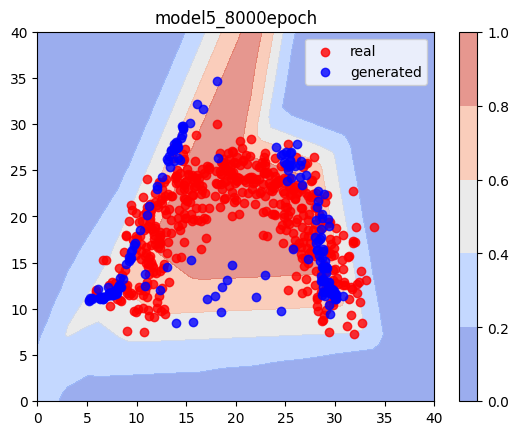

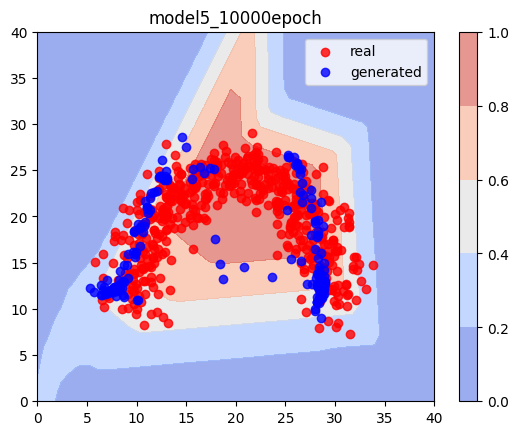

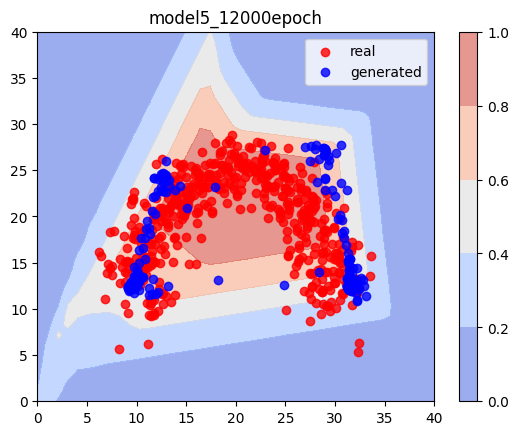

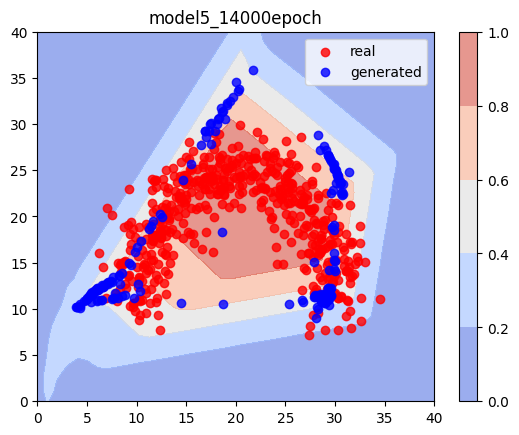

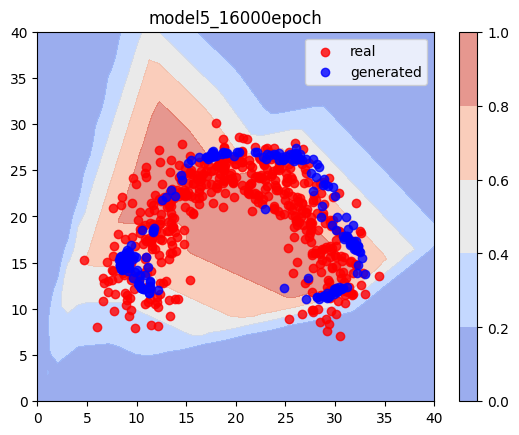

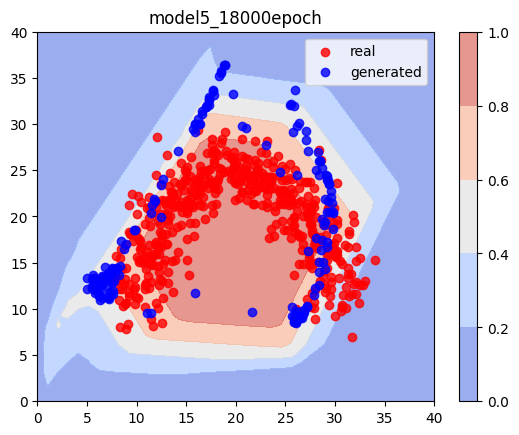

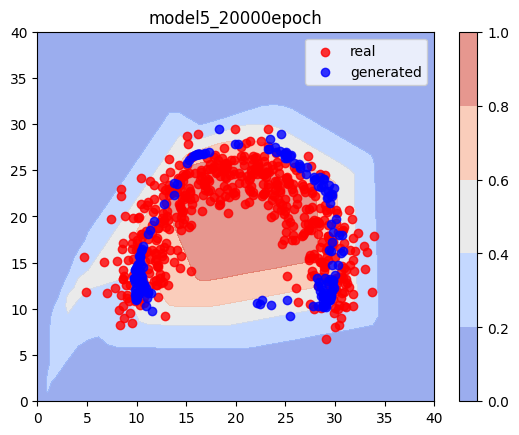

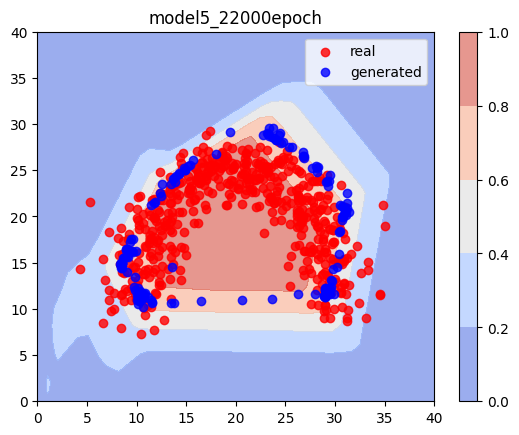

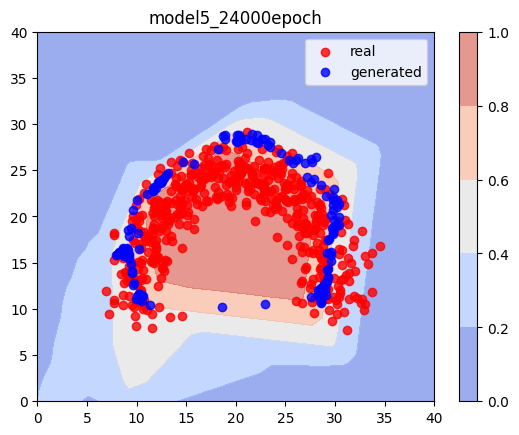

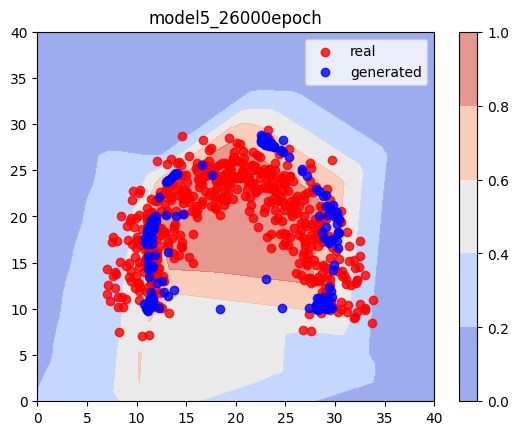

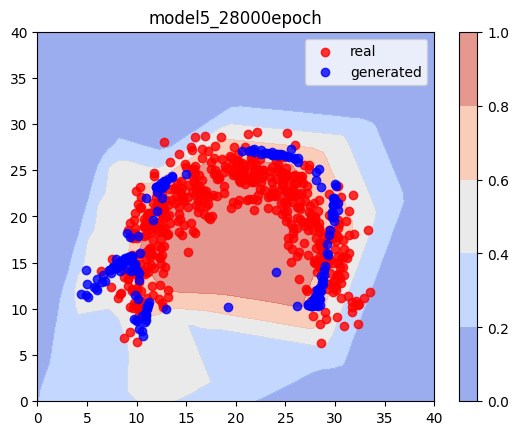

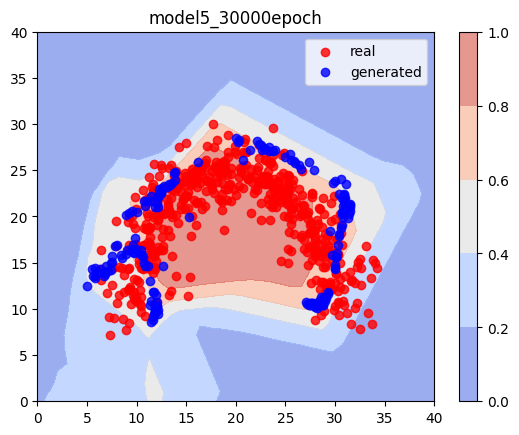

In [12]:
torch.manual_seed(0)
np.random.seed(0)

G = Generator(16).to(args.device)
D = Discriminator(8).to(args.device)

args.distribution = 'bow_shaped'
args.alpha = 0.75
args.beta = 5
args.gamma=0.4

G_optimizer = Adam(G.parameters(), lr=1e-3)
D_optimizer = Adam(D.parameters(), lr=1e-3)



for epoch in range(1, 50+1):
    d_loss = train_discriminator(D, G, D_optimizer, args)
    if epoch % 10 == 0:
        print("epoch:{}, d_loss:{}".format(epoch, d_loss))
        

for epoch in range(1, 30_000+1):
    d_loss = train_discriminator(D, G, D_optimizer, args)
    g_loss = train_generator(D, G, G_optimizer, args)
    if epoch % 1000 == 0:
        print("epoch:{}, d_loss:{}, g_loss:{}".format(epoch, d_loss, g_loss))
    if epoch % 2000 == 0:
        plot_boundary(G, D, args, title='model5_{}epoch'.format(epoch))
torch.save(G.state_dict(), "{}/model5_G.pth".format(args.models_dir))
torch.save(D.state_dict(), "{}/model5_D.pth".format(args.models_dir))